In [ ]:
from pyod.utils.data import generate_data

n_features = 100
n_samples = 200
train_percent = 0.8
n_pca_components = 4
desired_num_samples = 100

sampler_shots = 2000

X_train, X_test, y_train, y_test = generate_data(
    n_train=int(n_samples * train_percent),
    n_test=n_samples - int(n_samples * train_percent),
    n_features=n_features,
    contamination=0.1,
    random_state=42
)
# Anomalies should be labeled -1, normal points should be labeled 1
# Now they are 0 (normal) and 1 (anomaly)
y_train[y_train == 1] = -1
y_test[y_test == 1] = -1
y_train[y_train == 0] = 1
y_test[y_test == 0] = 1


In [86]:
# Use StandardScaler to scale the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [87]:
# Use PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=n_pca_components)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
print(f"Explained variance ratio: {sum(pca.explained_variance_ratio_):.2f}")


Explained variance ratio: 0.74


In [88]:
from sklearn.neighbors import LocalOutlierFactor

lof = LocalOutlierFactor(n_neighbors=20)
density_scores = -lof.fit_predict(X_train_pca)

# Keep samples with low density (potentially near anomalies)
keep_idx = density_scores.argsort()[:desired_num_samples]
X_train_resized = X_train_pca[keep_idx]
y_train_resized = y_train[keep_idx]

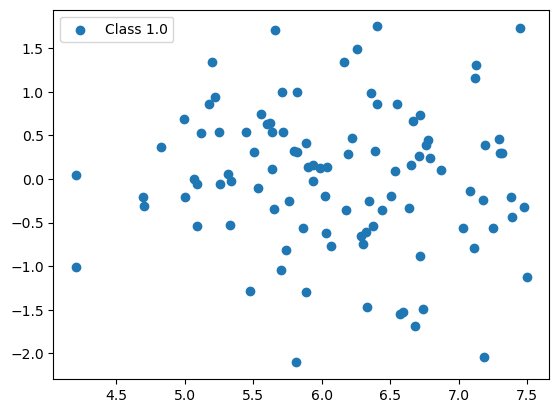

In [89]:
# Plot the data using feature 1 and feature 2
import matplotlib.pyplot as plt
import numpy as np
for c in np.unique(y_train_resized):
    plt.scatter(X_train_resized[y_train_resized==c, 0], X_train_resized[y_train_resized==c, 1], label=f'Class {c}')
plt.legend()
plt.show()


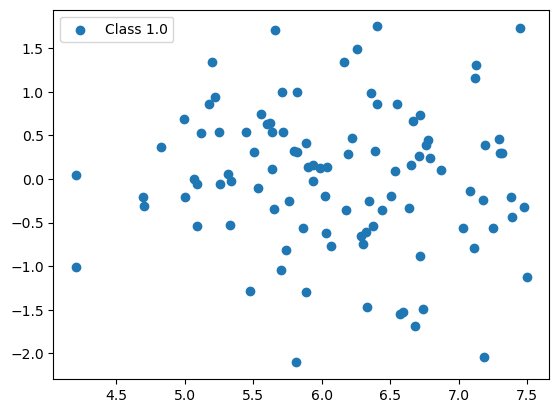

In [90]:
# Plot the data using PCA
from sklearn.decomposition import PCA
pca_vis = PCA(n_components=2)
X_pca_vis = pca_vis.fit_transform(X_train_resized)
for c in np.unique(y_train_resized):
    plt.scatter(X_train_resized[y_train_resized==c, 0], X_train_resized[y_train_resized==c, 1], label=f'Class {c}')
plt.legend()
plt.show()


In [91]:
# Make benchmark with OneClassSVM
from sklearn.svm import OneClassSVM
from sklearn.metrics import classification_report, accuracy_score
ocsvm = OneClassSVM()
ocsvm.fit(X_train_resized, y_train_resized)
# Print training accuracy
y_pred_train = ocsvm.predict(X_train_resized)
print("Training:")
print(classification_report(y_train_resized, y_pred_train))
# Print test accuracy
y_pred = ocsvm.predict(X_test_pca)
print("Test:")
print(classification_report(y_test, y_pred))


Training:
              precision    recall  f1-score   support

        -1.0       0.00      0.00      0.00         0
         1.0       1.00      0.50      0.67       100

    accuracy                           0.50       100
   macro avg       0.50      0.25      0.33       100
weighted avg       1.00      0.50      0.67       100

Test:
              precision    recall  f1-score   support

        -1.0       0.27      1.00      0.42         4
         1.0       1.00      0.69      0.82        36

    accuracy                           0.72        40
   macro avg       0.63      0.85      0.62        40
weighted avg       0.93      0.72      0.78        40



c:\Users\danel.a.a\AppData\Local\anaconda3\envs\ocqsvm\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\danel.a.a\AppData\Local\anaconda3\envs\ocqsvm\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\danel.a.a\AppData\Local\anaconda3\envs\ocqsvm\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metri

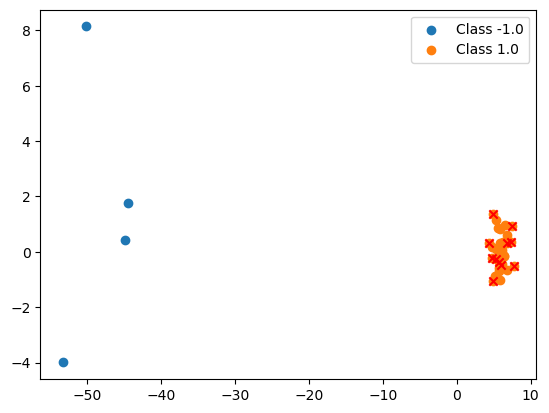

In [92]:
# Visualize the data putting red crosses on data not correctly classified (for test)
for c in np.unique(y_test):
    plt.scatter(X_test_pca[y_test==c, 0], X_test_pca[y_test==c, 1], label=f'Class {c}')
for i in range(len(y_test)):
    # red crosses for misclassified points
    if y_test[i] != y_pred[i]:
        plt.scatter(X_test_pca[i, 0], X_test_pca[i, 1], color='red', marker='x')
plt.legend()
plt.show()



In [93]:
n_qubits = X_train_resized.shape[1]
print(f"Number of qubits: {n_qubits}")

Number of qubits: 4


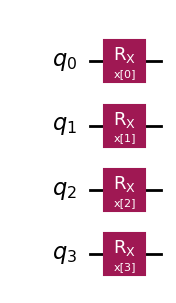

In [94]:
from qiskit.circuit.library import zz_feature_map
# Create the encoding circuit
# Circuit 1
#enc_qc = zz_feature_map(n_qubits,parameter_prefix='x')
# Circuit 2 (angle encoding in Rx)
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
params = ParameterVector('x', n_qubits)
enc_qc = QuantumCircuit(n_qubits)
for i in range(n_qubits):
    enc_qc.rx(params[i], i)

enc_qc.draw('mpl', fold=-1)

In [95]:
from OCQSVM import OneClassQSVM
from qiskit_machine_learning.kernels import FidelityQuantumKernel
from qiskit_machine_learning.state_fidelities import ComputeUncompute
from qiskit_ibm_runtime import Sampler
from qiskit_aer import AerSimulator
# Create the OneClassQSVM instance
compute_uncompute = ComputeUncompute(sampler=Sampler(mode=AerSimulator(), options={'default_shots': sampler_shots}))
kernel = FidelityQuantumKernel(feature_map=enc_qc,
                               fidelity=compute_uncompute)
ocqsvm = OneClassQSVM(quantum_kernel=kernel, verbose=True)
# Fit the model
ocqsvm.fit(X_train_resized, y_train_resized)

[LibSVM]

,quantum_kernel,<qiskit_machi...001E991CCFA80>
,cache_size,200
,coef0,0.0
,degree,3
,gamma,'scale'
,max_iter,-1
,nu,0.5
,shrinking,True
,tol,0.001
,verbose,True


In [96]:
# Print training accuracy
y_pred_train = ocqsvm.predict(X_train_resized)
print("Training:")
print(classification_report(y_train_resized, y_pred_train))
# Print test accuracy
y_pred = ocqsvm.predict(X_test_pca)
print("Test:")
print(classification_report(y_test, y_pred))

Training:
              precision    recall  f1-score   support

        -1.0       0.00      0.00      0.00         0
         1.0       1.00      0.50      0.67       100

    accuracy                           0.50       100
   macro avg       0.50      0.25      0.33       100
weighted avg       1.00      0.50      0.67       100



c:\Users\danel.a.a\AppData\Local\anaconda3\envs\ocqsvm\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\danel.a.a\AppData\Local\anaconda3\envs\ocqsvm\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\danel.a.a\AppData\Local\anaconda3\envs\ocqsvm\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metri

Test:
              precision    recall  f1-score   support

        -1.0       0.25      1.00      0.40         4
         1.0       1.00      0.67      0.80        36

    accuracy                           0.70        40
   macro avg       0.62      0.83      0.60        40
weighted avg       0.93      0.70      0.76        40



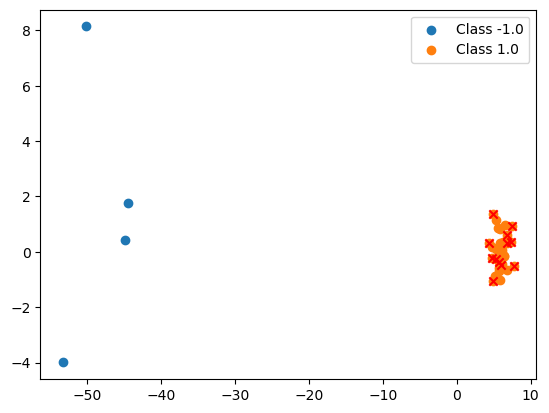

In [97]:
# Visualize the data
import matplotlib.pyplot as plt
for c in np.unique(y_test):
    plt.scatter(X_test_pca[y_test==c, 0], X_test_pca[y_test==c, 1], label=f'Class {c}')
for i in range(len(y_test)):
    # red crosses for misclassified points
    if y_test[i] != y_pred[i]:
        plt.scatter(X_test_pca[i, 0], X_test_pca[i, 1], color='red', marker='x')
plt.legend()
plt.show()